# Ideb x Média SIOPE

Aqui vamos pegar o arquivo que contémas médias de salários pagas por escolas + dados do censo escolar (tamanho da turma e código da escola) e ai vamos filtrar para as séries do ideb que vão receber a prova e juntar as notas do IDEB.

Informações sobre ideb:

"Planilhas com resultados": http://portal.inep.gov.br/artigo/-/asset_publisher/B4AQV9zFY7Bv/content/id/1511536
"Quem não faz a prova?": https://academia.qedu.org.br/ideb/notas-do-ideb-por-local/
"Nota Técnica do INEP": http://download.inep.gov.br/educacao_basica/portal_ideb/o_que_sao_as_metas/Artigo_projecoes.pdf


### Importando e limpando os dados do SIOPE + Censo escolar:

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
os.chdir("C:/Users/coliv/Documents/R-Projects/qualidade_gastos_educação/analise_gastos_siope/data/Cruzamentos")
siope_sp_escolas = pd.read_csv("media_salarios_por_escola.csv", index_col=0)

In [4]:
siope_escolas = siope_sp_escolas

#Tirando uma coluna unamed xapore que tinha no meu df:
siope_escolas = siope_escolas.loc[:, ~siope_escolas.columns.str.contains('^Unnamed')]

#Mudando os tipos de coluna num for loop:
for col in ['CO_UF', 'CO_MUNICIPIO', 'CO_ENTIDADE']:
    siope_escolas[col] = siope_escolas[col].astype('str')

#Eu percebi que agregar a etapa de ensino não iria mudar em nada. Ao invés de mudar na parte do 
# censo (média_salarios_por_escola.ipynb), vou primeiro resolver aqui:

siope_escolas = siope_escolas.groupby(['CO_UF', 'CO_MUNICIPIO', 
                                       'CO_ENTIDADE', 'NO_ENTIDADE', 
                                       'NO_MUNICIPIO', 'SALARIO_MEDIO', 
                                       'PERC_PART_FUNDEB' ], as_index = False).agg({'MATRICULAS_POR_ETAPA': 'sum'})

#df.rename(columns={"A": "a", "B": "c"})
siope_escolas = siope_escolas.rename(columns={'MATRICULAS_POR_ETAPA': 'QTDE_MATRICULAS'})

c:\users\coliv\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
#Vendo os tipos:
siope_escolas.head(1)

,CO_UF,CO_MUNICIPIO,CO_ENTIDADE,NO_ENTIDADE,NO_MUNICIPIO,SALARIO_MEDIO,PERC_PART_FUNDEB,QTDE_MATRICULAS
0,35,350010,35063113,SONHO DE CRIANCA CICLO I,Adamantina,3434.0,1.0,56


### Agora vou finalmente cruzar com o IDEB

In [5]:
#Abrindo
os.chdir("C:/Users/coliv/Documents/R-Projects/qualidade_gastos_educação/analise_gastos_siope/data/IDEB")
ideb_sp = pd.read_excel("ideb_sp.xlsx")

In [6]:
ideb = ideb_sp
ideb = ideb[['codigo_da_escola', 'ideb_2017_n_x_p', 'periodo']]

#Vou consertar o encoding na mão pq é só um:
ideb['periodo'] = np.where(ideb.periodo.str.contains('ensino'), 'ensino médio', ideb.periodo)

#Normalizando o código da entidade:
ideb = ideb.rename(columns = {'codigo_da_escola':'CO_ENTIDADE'})
ideb['CO_ENTIDADE'] = ideb['CO_ENTIDADE'].astype('str')

c:\users\coliv\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
siope_ideb = pd.merge(ideb, siope_escolas, on =['CO_ENTIDADE'], how = 'right')
siope_ideb['PERC_PART_FUNDEB'] = round(siope_ideb['PERC_PART_FUNDEB'], 2)

In [8]:
print(ideb.shape,  siope_ideb.shape)

(17104, 3) (13313, 10)


In [9]:
siope_ideb.head(1)

,CO_ENTIDADE,ideb_2017_n_x_p,periodo,CO_UF,CO_MUNICIPIO,NO_ENTIDADE,NO_MUNICIPIO,SALARIO_MEDIO,PERC_PART_FUNDEB,QTDE_MATRICULAS
0,35079911,65.0,primeiro a quarto ano,35,350010,EURICO LEITE DE MORAIS,Adamantina,3249.0,1.0,169


In [41]:
#Exportando:

os.chdir("C:/Users/coliv/Documents/R-Projects/qualidade_gastos_educação/analise_gastos_siope/data/Cruzamentos")
siope_ideb.to_csv(r'siope_ideb.csv')

## Parte 2: Analises

<function matplotlib.pyplot.show(*args, **kw)>

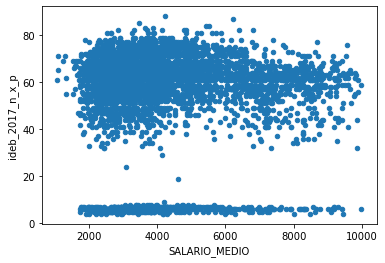

<Figure size 1080x360 with 0 Axes>

In [10]:
#Tem uns outliers doidos no siope, vamos retirar:
df = siope_ideb
df = df.query('SALARIO_MEDIO < 10000 ')


df.plot(x = 'SALARIO_MEDIO', y = 'ideb_2017_n_x_p', kind = 'scatter')
plt.figure(figsize = (15,5))
plt.show